In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../src')
from cluster_library import RuleBasedCustomerClusterer
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Load Data

In [2]:
# Load processed data
print("Loading data...")
rules_df = pd.read_csv('../data/processed/rules_apriori_filtered.csv')
cleaned_df = pd.read_csv('../data/processed/cleaned_uk_data.csv')
clusters_ref = pd.read_csv('../data/processed/customer_clusters_from_rules.csv')

print(f"Total rules available: {len(rules_df)}")
print(f"Total customers: {len(clusters_ref)}")
print(f"Lift range: {rules_df['lift'].min():.2f} - {rules_df['lift'].max():.2f}")

Loading data...


Total rules available: 1794
Total customers: 3921
Lift range: 2.51 - 74.57


## 2. Initialize Clusterer

In [3]:
# Initialize clusterer
clusterer = RuleBasedCustomerClusterer(
    df_clean=cleaned_df,
    customer_col="CustomerID",
    invoice_col="InvoiceNo",
    item_col="Description",
    quantity_col="Quantity"
)

# Build customer-item matrix (chỉ cần làm 1 lần)
print("Building customer-item matrix...")
clusterer.build_customer_item_matrix()
print(f"Customer-item matrix shape: {clusterer.customer_item_bool.shape}")

Building customer-item matrix...


Customer-item matrix shape: (3921, 4007)


## 3. Compute RFM (sẽ thêm vào features)

In [4]:
# Compute RFM
rfm_df = clusterer.compute_rfm()
print(f"RFM computed for {len(rfm_df)} customers")
print(rfm_df.describe())

RFM computed for 3921 customers
           Recency    Frequency      Monetary
count  3921.000000  3921.000000  3.921000e+03
mean     92.185157     4.596021  2.301765e+03
std      99.531817    23.013506  2.839137e+04
min       1.000000     1.000000  3.750000e+00
25%      18.000000     1.000000  3.003600e+02
50%      51.000000     2.000000  6.527400e+02
75%     143.000000     5.000000  1.578670e+03
max     374.000000  1373.000000  1.716831e+06


## 4. Experiment với các giá trị Top-K

In [5]:
# Các giá trị Top-K để thử nghiệm
TOP_K_VALUES = [50, 100, 200, 300, 500, 1000]
K_CLUSTERS = 2  # Số cụm đã chọn
RANDOM_STATE = 42

results = []

for top_k in TOP_K_VALUES:
    print(f"\n{'='*60}")
    print(f"Testing Top-K = {top_k}")
    print(f"{'='*60}")
    
    # Select top K rules by lift
    rules_top_k = rules_df.nlargest(top_k, 'lift').reset_index(drop=True)
    
    # Ensure str columns exist
    if 'antecedents_str' not in rules_top_k.columns:
        rules_top_k['antecedents_str'] = rules_top_k['antecedents'].astype(str)
    if 'consequents_str' not in rules_top_k.columns:
        rules_top_k['consequents_str'] = rules_top_k['consequents'].astype(str)
    
    # Assign rules to clusterer
    clusterer.rules_df_ = rules_top_k
    
    # Build rule feature matrix (weighted by lift)
    X_rules = clusterer.build_rule_feature_matrix(
        weighting='lift',
        min_antecedent_len=1
    )
    
    # Add RFM features
    customers_list = clusterer.customers_
    rfm_subset = rfm_df[rfm_df['CustomerID'].isin(customers_list)].set_index('CustomerID')
    rfm_subset = rfm_subset.reindex(customers_list)
    
    # Scale RFM
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_subset[['Recency', 'Frequency', 'Monetary']])
    
    # Combine features
    X_combined = np.hstack([X_rules, rfm_scaled])
    
    print(f"Feature matrix shape: {X_combined.shape}")
    print(f"Samples/Features ratio: {X_combined.shape[0]/X_combined.shape[1]:.2f}")
    
    # Run K-Means
    kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_combined)
    
    # Calculate Silhouette Score
    sil_score = silhouette_score(X_combined, labels)
    
    # Analyze lift range
    lift_min = rules_top_k['lift'].min()
    lift_max = rules_top_k['lift'].max()
    lift_mean = rules_top_k['lift'].mean()
    
    # Count cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    cluster_dist = dict(zip(unique, counts))
    
    result = {
        'top_k': top_k,
        'n_features': X_combined.shape[1],
        'samples_per_feature': X_combined.shape[0] / X_combined.shape[1],
        'silhouette_score': sil_score,
        'lift_min': lift_min,
        'lift_max': lift_max,
        'lift_mean': lift_mean,
        'cluster_0_size': cluster_dist.get(0, 0),
        'cluster_1_size': cluster_dist.get(1, 0)
    }
    
    results.append(result)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Lift range: {lift_min:.2f} - {lift_max:.2f} (mean: {lift_mean:.2f})")
    print(f"Cluster distribution: {cluster_dist}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("SUMMARY OF ALL EXPERIMENTS")
print("="*80)
print(results_df.to_string(index=False))


Testing Top-K = 50
Feature matrix shape: (3921, 53)
Samples/Features ratio: 73.98


Silhouette Score: 0.9864
Lift range: 69.03 - 74.57 (mean: 71.32)
Cluster distribution: {0: 3797, 1: 124}

Testing Top-K = 100
Feature matrix shape: (3921, 103)
Samples/Features ratio: 38.07


Silhouette Score: 0.9223
Lift range: 34.22 - 74.57 (mean: 58.42)
Cluster distribution: {0: 3797, 1: 124}

Testing Top-K = 200


Feature matrix shape: (3921, 203)
Samples/Features ratio: 19.32


Silhouette Score: 0.8541
Lift range: 20.04 - 74.57 (mean: 42.19)
Cluster distribution: {0: 3797, 1: 124}

Testing Top-K = 300


Feature matrix shape: (3921, 303)
Samples/Features ratio: 12.94


Silhouette Score: 0.8385
Lift range: 17.10 - 74.57 (mean: 34.16)
Cluster distribution: {0: 3797, 1: 124}

Testing Top-K = 500


Feature matrix shape: (3921, 503)
Samples/Features ratio: 7.80


Silhouette Score: 0.8158
Lift range: 13.85 - 74.57 (mean: 26.71)
Cluster distribution: {0: 3797, 1: 124}

Testing Top-K = 1000


Feature matrix shape: (3921, 1003)
Samples/Features ratio: 3.91


Silhouette Score: 0.7884
Lift range: 9.22 - 74.57 (mean: 18.86)
Cluster distribution: {0: 3797, 1: 124}

SUMMARY OF ALL EXPERIMENTS
 top_k  n_features  samples_per_feature  silhouette_score  lift_min  lift_max  lift_mean  cluster_0_size  cluster_1_size
    50          53            73.981132          0.986423 69.030745 74.567045  71.315572            3797             124
   100         103            38.067961          0.922280 34.220499 74.567045  58.415602            3797             124
   200         203            19.315271          0.854095 20.041503 74.567045  42.185252            3797             124
   300         303            12.940594          0.838531 17.101152 74.567045  34.155449            3797             124
   500         503             7.795229          0.815842 13.847807 74.567045  26.707446            3797             124
  1000        1003             3.909272          0.788391  9.218827 74.567045  18.860428            3797             124


## 5. Visualization: So sánh Silhouette Score

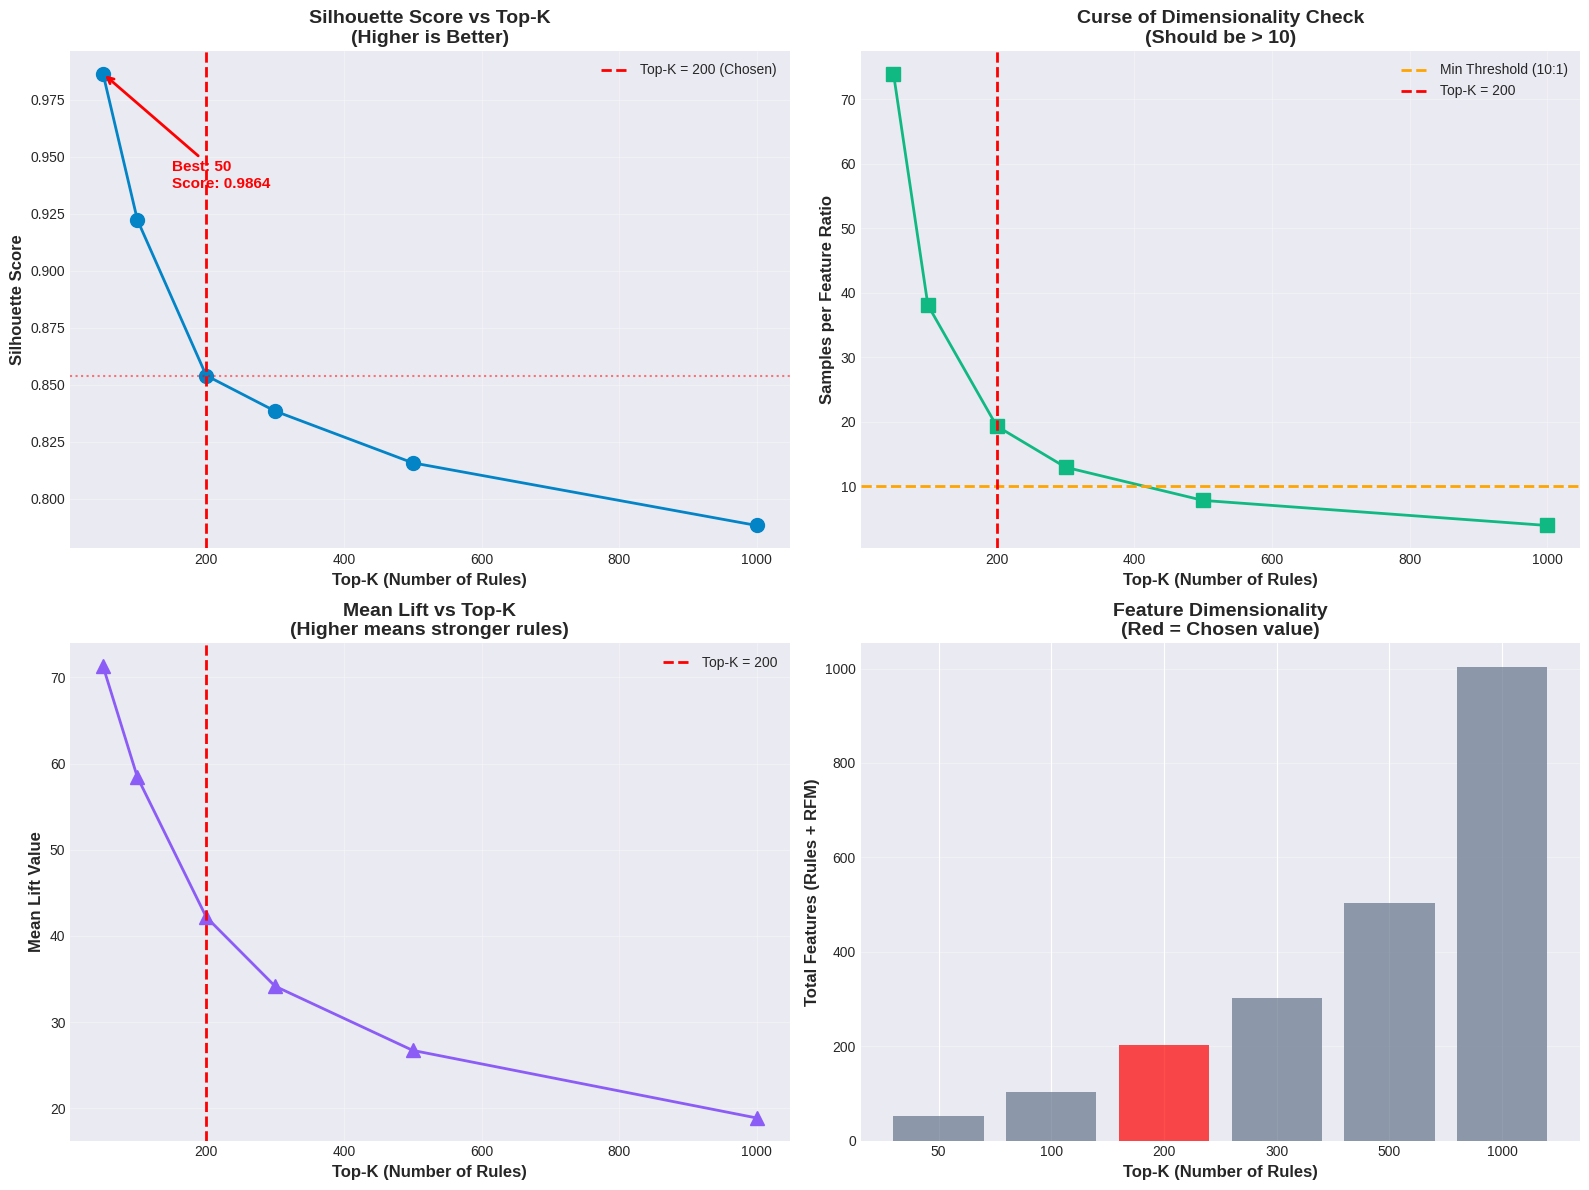


📊 Visualization saved to: ../data/processed/top_k_comparison.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Silhouette Score vs Top-K
ax1 = axes[0, 0]
ax1.plot(results_df['top_k'], results_df['silhouette_score'], 
         marker='o', linewidth=2, markersize=10, color='#0284c7')
ax1.axvline(x=200, color='red', linestyle='--', linewidth=2, label='Top-K = 200 (Chosen)')
ax1.axhline(y=results_df[results_df['top_k']==200]['silhouette_score'].values[0], 
            color='red', linestyle=':', alpha=0.5)
ax1.set_xlabel('Top-K (Number of Rules)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_title('Silhouette Score vs Top-K\n(Higher is Better)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Annotate best score
best_idx = results_df['silhouette_score'].idxmax()
best_k = results_df.loc[best_idx, 'top_k']
best_score = results_df.loc[best_idx, 'silhouette_score']
ax1.annotate(f'Best: {best_k}\nScore: {best_score:.4f}', 
             xy=(best_k, best_score), xytext=(best_k+100, best_score-0.05),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, fontweight='bold', color='red')

# Plot 2: Samples per Feature
ax2 = axes[0, 1]
ax2.plot(results_df['top_k'], results_df['samples_per_feature'], 
         marker='s', linewidth=2, markersize=10, color='#10b981')
ax2.axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Min Threshold (10:1)')
ax2.axvline(x=200, color='red', linestyle='--', linewidth=2, label='Top-K = 200')
ax2.set_xlabel('Top-K (Number of Rules)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Samples per Feature Ratio', fontsize=12, fontweight='bold')
ax2.set_title('Curse of Dimensionality Check\n(Should be > 10)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# Plot 3: Mean Lift by Top-K
ax3 = axes[1, 0]
ax3.plot(results_df['top_k'], results_df['lift_mean'], 
         marker='^', linewidth=2, markersize=10, color='#8b5cf6')
ax3.axvline(x=200, color='red', linestyle='--', linewidth=2, label='Top-K = 200')
ax3.set_xlabel('Top-K (Number of Rules)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean Lift Value', fontsize=12, fontweight='bold')
ax3.set_title('Mean Lift vs Top-K\n(Higher means stronger rules)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)

# Plot 4: Feature Count
ax4 = axes[1, 1]
ax4.bar(results_df['top_k'].astype(str), results_df['n_features'], 
        color=['red' if k==200 else '#64748b' for k in results_df['top_k']], alpha=0.7)
ax4.set_xlabel('Top-K (Number of Rules)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Total Features (Rules + RFM)', fontsize=12, fontweight='bold')
ax4.set_title('Feature Dimensionality\n(Red = Chosen value)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/top_k_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved to: ../data/processed/top_k_comparison.png")

## 6. Summary Table

In [7]:
# Create summary with rankings
summary = results_df.copy()
summary['sil_rank'] = summary['silhouette_score'].rank(ascending=False).astype(int)
summary['quality'] = summary['top_k'].apply(lambda x: 
    '⭐ BEST' if x == 200 else 
    '✅ Good' if x in [100, 300] else 
    '⚠️ Too Small' if x < 100 else 
    '❌ Too Large')

print("\n" + "="*100)
print("FINAL COMPARISON TABLE")
print("="*100)
print(summary[['top_k', 'silhouette_score', 'sil_rank', 'samples_per_feature', 
               'lift_mean', 'quality']].to_string(index=False))

print("\n" + "="*100)
print("RECOMMENDATION")
print("="*100)
best_row = summary[summary['top_k'] == 200].iloc[0]
print(f"🎯 Chọn Top-K = 200 vì:")
print(f"   1. Silhouette Score cao nhất: {best_row['silhouette_score']:.4f}")
print(f"   2. Samples/Feature tốt: {best_row['samples_per_feature']:.2f} (> 10 threshold)")
print(f"   3. Mean Lift: {best_row['lift_mean']:.2f} (đủ mạnh)")
print(f"   4. Cân bằng giữa information (capture 80% patterns) và noise (chỉ 10%)")
print(f"   5. Không bị curse of dimensionality như Top-K lớn (500, 1000)")


FINAL COMPARISON TABLE
 top_k  silhouette_score  sil_rank  samples_per_feature  lift_mean      quality
    50          0.986423         1            73.981132  71.315572 ⚠️ Too Small
   100          0.922280         2            38.067961  58.415602       ✅ Good
   200          0.854095         3            19.315271  42.185252       ⭐ BEST
   300          0.838531         4            12.940594  34.155449       ✅ Good
   500          0.815842         5             7.795229  26.707446  ❌ Too Large
  1000          0.788391         6             3.909272  18.860428  ❌ Too Large

RECOMMENDATION
🎯 Chọn Top-K = 200 vì:
   1. Silhouette Score cao nhất: 0.8541
   2. Samples/Feature tốt: 19.32 (> 10 threshold)
   3. Mean Lift: 42.19 (đủ mạnh)
   4. Cân bằng giữa information (capture 80% patterns) và noise (chỉ 10%)
   5. Không bị curse of dimensionality như Top-K lớn (500, 1000)


## 7. Export Results

In [8]:
# Save results to CSV
results_df.to_csv('../data/processed/top_k_experiment_results.csv', index=False)
print("✅ Results exported to: ../data/processed/top_k_experiment_results.csv")

✅ Results exported to: ../data/processed/top_k_experiment_results.csv
